# Classification

Import the libraries necessary to analize data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score


In [17]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              187534 non-null  datetime64[ns]
 1   state                             187534 non-null  object        
 2   city_or_county                    187534 non-null  object        
 3   latitude                          187534 non-null  float64       
 4   longitude                         187534 non-null  float64       
 5   congressional_district            187534 non-null  int64         
 6   avg_age_participants              187534 non-null  float64       
 7   n_participants_child              187534 non-null  int64         
 8   n_participants_teen               187534 non-null  int64         
 9   n_females                         187534 non-null  float64       
 10  n_killed                        

In [18]:
#check if there is any null value
df.isnull().values.any()

False

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute involve_killing

In [19]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              187534 non-null  datetime64[ns]
 1   state                             187534 non-null  object        
 2   city_or_county                    187534 non-null  object        
 3   latitude                          187534 non-null  float64       
 4   longitude                         187534 non-null  float64       
 5   congressional_district            187534 non-null  int64         
 6   avg_age_participants              187534 non-null  float64       
 7   n_participants_child              187534 non-null  int64         
 8   n_participants_teen               187534 non-null  int64         
 9   n_females                         187534 non-null  float64       
 10  n_killed                        

In [20]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','state','city_or_county','congressional_district', 'incident_characteristics1']] 

corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
corr_matrix_ind

avg_age_participants  n_participants_child  \
avg_age_participants                          1.000000             -0.175278   
n_participants_child                         -0.175278              1.000000   
n_participants_teen                          -0.289719              0.011801   
n_females                                     0.057621              0.143355   
n_killed                                      0.126576              0.063632   
n_injured                                    -0.102553              0.053361   
n_arrested                                   -0.047418             -0.011199   
n_unharmed                                   -0.015379              0.110597   
n_participants                               -0.050232              0.131445   
povertyPercentage                             0.027709              0.031221   
candidatevotes                               -0.009897             -0.023458   
totalvotes                                    0.012246             -0.026072   
child_percentage_per_district                -0.144844              0.739767   
teen_percentage_per_district                 -0.188539              0.008228   
killed_percentage_per_district                0.129176              0.046680   
injured_percentage_per_district              -0.017038              0.033203   
arrested_percentage_per_district             -0.011172             -0.002922   
unharmed_percentage_per_district              0.009028              0.056719   
killed_rate                                   0.130686              0.011440   
injured_rate                                 -0.109933              0.019320   
arrested_rate                                 0.000421             -0.042073   
survival_rate                                 0.004519              0.048676   
n_harmed                                     -0.045261              0.062452   
winning_party_percentage                     -0.033316              0.005658   
involve_killing                               0.108380              0.020479   

                                  n_participants_teen  n_females  n_killed  \
avg_age_participants                        -0.289719   0.057621  0.126576   
n_participants_child                         0.011801   0.143355  0.063632   
n_participants_teen                          1.000000   0.095079  0.015531   
n_females                                    0.095079   1.000000  0.178922   
n_killed                                     0.015531   0.178922  1.000000   
n_injured                                    0.111810   0.167129 -0.182932   
n_arrested                                   0.191621   0.169556 -0.031980   
n_unharmed                                   0.082485   0.188492 -0.103562   
n_participants                               0.262196   0.430273  0.220567   
povertyPercentage                            0.013198   0.052073  0.066325   
candidatevotes                              -0.014046  -0.030701 -0.052148   
totalvotes                                  -0.019221  -0.033256 -0.074770   
child_percentage_per_district                0.010006   0.109145  0.057373   
teen_percentage_per_district                 0.615982   0.064554  0.023681   
killed_percentage_per_district               0.005996   0.134572  0.639794   
injured_percentage_per_district              0.051184   0.091590 -0.073415   
arrested_percentage_per_district             0.092784   0.084252  0.008883   
unharmed_percentage_per_district             0.033594   0.098078 -0.057713   
killed_rate                                 -0.032620   0.040933  0.859053   
injured_rate                                 0.026612  -0.005063 -0.290224   
arrested_rate                                0.067483   0.010042 -0.144310   
survival_rate                                0.011639   0.084376 -0.143200   
n_harmed                                     0.234493   0.342530  0.334891   
winning_party_percentage                     0.005544   0.005547  0.035659   
inv

<Axes: >

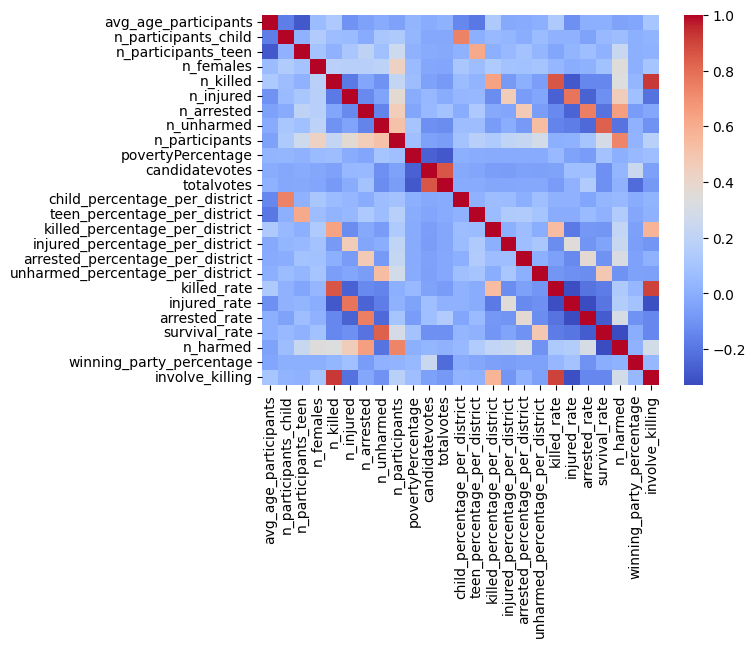

In [21]:
sns.heatmap(corr_matrix_ind, annot=False, cmap='coolwarm')

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [22]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [23]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

In [24]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   latitude                          187534 non-null  float64
 1   longitude                         187534 non-null  float64
 2   congressional_district            187534 non-null  int64  
 3   avg_age_participants              187534 non-null  float64
 4   n_participants_child              187534 non-null  int64  
 5   n_participants_teen               187534 non-null  int64  
 6   n_females                         187534 non-null  float64
 7   n_killed                          187534 non-null  float64
 8   n_injured                         187534 non-null  float64
 9   n_arrested                        187534 non-null  float64
 10  n_unharmed                        187534 non-null  float64
 11  n_participants                    187534 non-null  f

In [25]:
df.drop(columns=['n_killed', 'killed_rate','survival_rate','candidatevotes','n_injured','n_arrested','killed_percentage_per_district','longitude','latitude'], axis=1,inplace=True)

In [26]:
label = df.pop('involve_killing')

Percentage of incidents that involve killing over the total number of incidents we consider, as we can see the dataset is unbalanced towards the non killing label

In [27]:
label.sum() / label.count()

0.233824266533002

We partitioned the dataset into training, validation, and test sets using a 70/15/15 split. Additionally, by merging the training and validation sets, we established a development set, comprising 85% of the data, since certain models do not necessitate validation.

In [28]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.15,random_state=10, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_trvl, y_trvl, test_size=0.18,random_state=10, stratify=y_trvl)

Standardization of the data

In [29]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_train = scaler.fit_transform(X_train)
X_sc_val = scaler.fit_transform(X_val)
X_sc_test = scaler.fit_transform(X_test)

In [30]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

These are the metrics used to evaluate the classification goodness.

In [31]:
from sklearn import metrics

def print_accuracy(y_train,train_pred,test_pred):
    print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred))
    print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred))
    print('Precision train set ', metrics.precision_score(y_train, train_pred, average='weighted'))
    print('Recall train set ', metrics.recall_score(y_train, train_pred, average='weighted'))
    print('F1 score train set ', metrics.f1_score(y_train, train_pred, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred))
    print("\n")

In [32]:
# Functions that prints the classification report
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['non-killing', 'killing']))

## Decision tree

import libraries to create Decision tree

In [33]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier


We fit the decision tree on our training data.

In [34]:
params = [{
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [3,4,5,6,None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2,3,4,5,6,10],
    'min_samples_leaf': [2,3,4,5,6,10]
    }] 
grd_tree = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=10)
grd_tree.fit(X_sc_trvl, y_trvl)
print("DT - Best parameters during validation set found:")
print(grd_tree.best_params_)
print("DT - Best accuraccy during validation score found:")
print(grd_tree.best_score_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


KeyboardInterrupt: 

In [132]:


# best parametrs from validation:  criterion='gini', splitter='best', max_depth=None, max_features = None, min_samples_split=4, min_samples_leaf=30

dt = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=None, max_features = None, min_samples_split=4, min_samples_leaf=30)
#train model on development set
dt = dt.fit(X_sc_trvl, y_trvl)


This yields the following decision tree.

In [133]:

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=list(X_trvl.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.437412 to fit



The predicted values obtained using the decision tree are then computed.

In [1]:
train_validation_pred_dt = dt.predict(X_sc_trvl)
test_pred_dt = dt.predict(X_sc_test)
print_accuracy(y_trvl,train_validation_pred_dt,test_pred_dt)
print("Testing:")
report_scores(y_test,test_pred_dt)

NameError: name 'dt' is not defined

The following are the values of the confusion matrix.

In [140]:
cm = confusion_matrix(y_test, test_pred_dt)
cm

array([[21171,   382],
       [  273,  6305]], dtype=int64)

We plotted the confusion matrix.

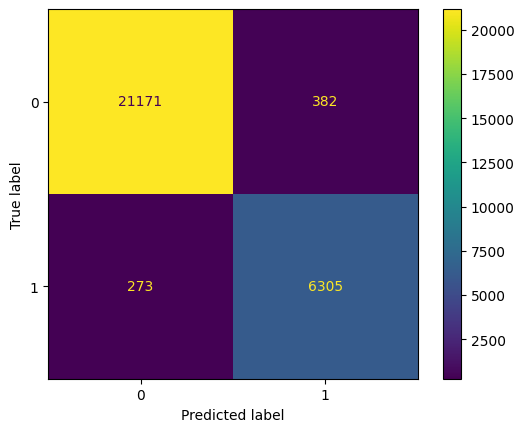

In [141]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

We plotted the scatter plot for the classification values on the test set.

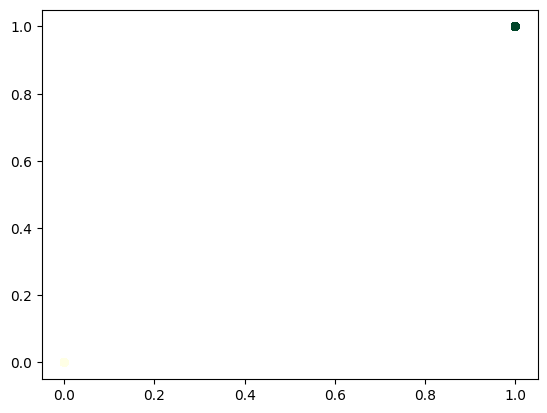

In [143]:

# TODO sistemare questa riga
plt.scatter(X_sc_test.iloc[:, 5].values, X_sc_test.iloc[:, 2].values, c=test_pred_dt.values, s=25, cmap='YlGn')

## Naive Bayes

Bayes theorem is used to compute the probability of an instance belonging to a given class given some prior knowledge.
We fit the model on our training data.

In [144]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_sc_train, y_train)
train_pred_gnb = gnb.predict(X_sc_train)
val_pred_gnb = gnb.predict(X_sc_val)
print("Validation: ")
report_scores(y_val,val_pred_gnb)

Validation: 
              precision    recall  f1-score   support

 non-killing       0.86      0.94      0.90     21984
     killing       0.72      0.48      0.58      6709

    accuracy                           0.83     28693
   macro avg       0.79      0.71      0.74     28693
weighted avg       0.82      0.83      0.82     28693



In [145]:
from sklearn.naive_bayes import BernoulliNB
brlbn = BernoulliNB()
brlbn.fit(X_train, y_train)
val_pred_brlbn = brlbn.predict(X_val)
print("Validation: ")
report_scores(y_val,val_pred_brlbn)


Validation: 
              precision    recall  f1-score   support

 non-killing       0.88      0.86      0.87     21984
     killing       0.58      0.63      0.61      6709

    accuracy                           0.81     28693
   macro avg       0.73      0.75      0.74     28693
weighted avg       0.81      0.81      0.81     28693



In [146]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Validation: ")
report_scores(y_val,y_pred)

Validation: 
              precision    recall  f1-score   support

 non-killing       0.78      0.51      0.62     21984
     killing       0.25      0.53      0.34      6709

    accuracy                           0.52     28693
   macro avg       0.52      0.52      0.48     28693
weighted avg       0.66      0.52      0.55     28693



In [147]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(X_train, y_train)
y_pred_cp = model.predict(X_val)
print("Validation: ")
report_scores(y_val,y_pred_cp)

Validation: 
              precision    recall  f1-score   support

 non-killing       0.78      0.51      0.62     21984
     killing       0.25      0.53      0.34      6709

    accuracy                           0.52     28693
   macro avg       0.52      0.52      0.48     28693
weighted avg       0.66      0.52      0.55     28693



We chose the best among the classifiers, based on validation set and tested it.

In [148]:
test_pred_gnb = gnb.predict(X_sc_test)
train_pred_gnb  = gnb.predict(X_sc_trvl)
print_accuracy(y_trvl,train_pred_gnb,test_pred_gnb)
print("Test set:")
report_scores(y_test,test_pred_gnb)


Accuracy train set  0.8348940402417565
Accuracy test set  0.8359105613024777
Precision train set  0.8243212462701784
Recall train set  0.8348940402417565
F1 score train set  0.8229222681319845
Support train set  (array([0.85716364, 0.71670527]), array([0.94137618, 0.48597978]), array([0.89729838, 0.57921111]), array([100147,  30563], dtype=int64))


Test set:
              precision    recall  f1-score   support

 non-killing       0.86      0.94      0.90     21553
     killing       0.72      0.49      0.58      6578

    accuracy                           0.84     28131
   macro avg       0.79      0.72      0.74     28131
weighted avg       0.83      0.84      0.82     28131



We plotted the scatter plot for the classification values on the test set.

In [307]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_gnb.values, s=25, cmap='YlGn')

The following are the values of the confusion matrix.

In [149]:
cm = confusion_matrix(y_test, test_pred_gnb)
cm

array([[20288,  1265],
       [ 3351,  3227]], dtype=int64)

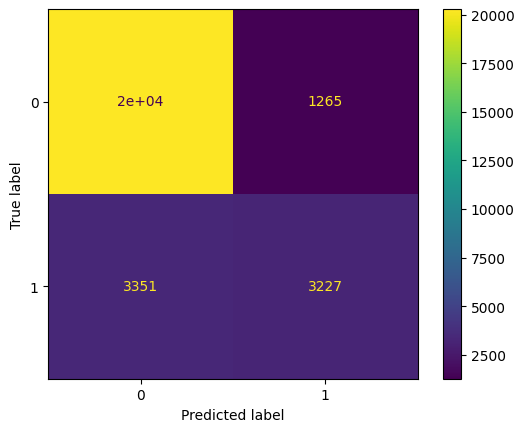

In [150]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()
plt.show()

## Random Forest

import libraries for random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier


### Grid search for parameter setting

In order to find the best parameters we use a grid search.
The parameters values we want to find are the following.

In [2]:


params = [{
'max_depth': [5, 15, None],
'max_features': ['log2', None],
'min_samples_leaf': [1, 2, 4],
'n_estimators': [32, 64, 128],
"bootstrap": [True, False],
"criterion": ["entropy", "gini"],
"class_weight":['balanced', None, {0: 0.3, 1: 0.7}]
}] 

rd_fr_grid = GridSearchCV(RandomForestClassifier(), params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
rd_fr_grid.fit(X_sc_trvl, y_trvl)
print("RF - Best parameters set for validation found:")
print(rd_fr_grid.best_params_)
print("RF - Best accuraccy score on validation found:")
print(rd_fr_grid.best_score_)

NameError: name 'GridSearchCV' is not defined

We print the best values we found for these parameters, along with their means and standard deviation.

In [313]:
print('Best setting parameters ', rd_fr_grid.cv_results_['params'][0])
print('Mean and std of this setting ', rd_fr_grid.cv_results_['mean_test_score'][0], 
      rd_fr_grid.cv_results_['std_test_score'][0])

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

We run the classifier and compute the perfomance scores.

In [ ]:
test_pred_rf = rd_fr_grid.predict(X_sc_test)
trvl_pred_rf = rd_fr_grid.predict(X_sc_trvl)
print_accuracy(y_trvl,trvl_pred_rf,test_pred_rf)
report_scores(y_test, test_pred_rf)

              precision    recall  f1-score   support

 non-killing       0.99      0.91      0.95     21553
     killing       0.78      0.98      0.87      6578

    accuracy                           0.93     28131
   macro avg       0.88      0.95      0.91     28131
weighted avg       0.94      0.93      0.93     28131



In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


## AdaBoost

import libraries for AdaBoost

In [35]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


Grid search AdaBoost

In [36]:

def getAdaBoostBaseAlgo(num):
    if num == 0:
        return DecisionTreeClassifier(max_depth=5)
    elif num == 1:
        return SVC(probability=True, kernel='rbf')
    elif num == 2:
        return RandomForestClassifier(max_depth=5)
    elif num == 3:
        return LogisticRegression()
                


In [41]:


params = {
'base_estimator': [getAdaBoostBaseAlgo(0),getAdaBoostBaseAlgo(1),getAdaBoostBaseAlgo(2),getAdaBoostBaseAlgo(3)],
'n_estimators': [10,20,30,100,200,300], # The maximum number of estimators at which boosting is terminated.
'learning_rate': [1,0.1],
'random_state': [None]
}
ada_boost_grid = GridSearchCV(AdaBoostClassifier(), params,refit = True, cv=cv_strategy ,scoring='accuracy', n_jobs=10, verbose=10)
ada_boost_grid.fit(X_sc_trvl, y_trvl)
print("Ada Boost - Best parameters set found:")
print(ada_boost_grid.best_params_)
print("Ada Boost - Best accuraccy score found:")
print(ada_boost_grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Ada Boost - Best parameters set found:
{'base_estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 1, 'n_estimators': 10, 'random_state': None}
Ada Boost - Best accuraccy score found:
0.9724597466968306


In [ ]:
test_pred_ada_boost = ada_boost_grid.predict(X_sc_test)
trvl_pred_ada_boost = ada_boost_grid.predict(X_sc_trvl)
print_accuracy(y_trvl,trvl_pred_ada_boost,test_pred_ada_boost)
report_scores(y_test,test_pred_ada_boost)


              precision    recall  f1-score   support

  no-killing       0.97      0.97      0.97     21553
     killing       0.91      0.91      0.91      6578

    accuracy                           0.96     28131
   macro avg       0.94      0.94      0.94     28131
weighted avg       0.96      0.96      0.96     28131



In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_ada_boost.values, s=25, cmap='YlGn')

ValueError: Found input variables with inconsistent numbers of samples: [28131, 130710]

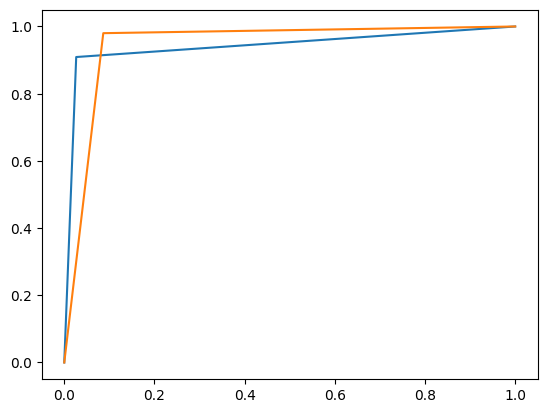

In [277]:


plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_ada_boost)
auc = metrics.roc_auc_score(y_test, test_pred_ada_boost)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

## KNN

import libraries for K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

In [ ]:


metrics = [
'euclidean', 
'minkowski',
'chebyshev',
'cosine',
]
params = [{
    'n_neighbors': [100,130,160,190,200,250,300,400,500,600,700,800,900,1000,1100,1200],
    'algorithm':['auto','ball_tree'], 
    'metric':metrics, 
    'weights':["distance","uniform"]}]
    
knn_grid = GridSearchCV(KNeighborsClassifier(p = 1), params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
knn_grid.fit(X_sc_trvl, y_trvl)
print("K_nn - Best parameters set found:")
print(knn_grid.best_params_)
print("K_nn - Best accuraccy score found:")
print(knn_grid.best_score_)

We run the prediction and evaluate the performance scores for this model.

In [ ]:
test_pred_knn = knn_grid.predict(X_sc_test)
train_pred_knn = knn_grid.predict(X_sc_trvl)
print_accuracy(y_trvl,train_pred_knn,test_pred_knn)
report_scores(y_test,test_pred_knn)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     45482
           1       0.98      0.78      0.87     13893

    accuracy                           0.94     59375
   macro avg       0.96      0.89      0.92     59375
weighted avg       0.95      0.94      0.94     59375



In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_knn.values, s=25, cmap='YlGn')


## SVM

In [ ]:
import scikitplot as skplt


In [ ]:

params = [
{"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1,0.5, 1, 10, 100, 300, 1000]},
{"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1,0.5, 1, 10, 100, 300, 1000]},#C term that gives more freedom for classification errors.
] 
svc_grid = GridSearchCV(SVC(), params, refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=10)
svc_grid.fit(X_sc_trvl, y_train)
print("SVM - Best parameters set found:")
print(svc_grid.best_params_)
print("SVM - Best accuracy score found:")
print(svc_grid.best_score_)

We run the prediction on our test set.

In [ ]:
test_pred_proba_svm = svc_grid.predict_proba(X_sc_test)
trvl_pred_proba_svm = svc_grid.predict_proba(X_sc_trvl)
print_accuracy(y_trvl,trvl_pred_proba_svm,test_pred_proba_svm)
report_scores(y_test,test_pred_proba_svm)

We plot the ROC curve in order to estimate the goodness of our classification.

In [318]:
skplt.metrics.plot_roc(y_test.values, test_pred_proba_svm)
plt.show()

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_proba_svm.values, s=25, cmap='YlGn')


## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw


In [ ]:
ripper = lw.RIPPER()
params = [{
"prune_size": [0.5, 0.6], 
"k": [1, 3, 5]
}]
ripper_grid = GridSearchCV(estimator=ripper,params = params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
ripper_grid.fit(X_sc_trvl, y_trvl)
print("Ripper - Best parameters set found:")
print(ripper_grid.best_params_)
print("Ripper - Best accuraccy score found:")
print(ripper_grid.best_score_)

In [ ]:
ripper = lw.RIPPER()
params = [{
"prune_size": [0.5, 0.6], 
"k": [1, 3, 5]
}]
ripper_grid = GridSearchCV(estimator=ripper,params = params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
ripper_grid.fit(X_sc_trvl, y_trvl)
print("Ripper - Best parameters set found:")
print(ripper_grid.best_params_)
print("Ripper - Best accuraccy score found:")
print(ripper_grid.best_score_)

We run the model using the configuration found with grid search.

In [ ]:
ripper = lw.RIPPER(k=1, prune_size=0.50) #TODO sistemare con il risultato della validazione 
datas = pd.concat([X_sc_trvl, y_trvl], axis=1)
ripper.fit(datas, class_feat='involve_killing', pos_class=1) 

The rules yielded by the RIPPER model are the following.

In [ ]:
ripper.out_model()

We predict the class values using the rules found above.

In [ ]:
ripper.predict(y_test)

In order to evaluate the goodness of this classfication we compute the performance metrics.

In [ ]:
print('Accuracy ', ripper.score(X_sc_test, y_test))
print('Precision ', ripper.score(X_sc_test, y_test, precision_score))
print('Recall ', ripper.score(X_sc_test, y_test, recall_score))


with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
ripper.predict(X_sc_test[:20], give_reasons=True) #Explain the rules behind the first 20 instances that are classified as positive.

## Neural Network

imports of libraries to create NN

In [61]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
from keras.losses import binary_crossentropy


We start by considering a neural network composed by one layer.

In [68]:
def createModel(layersConfig,dropout, hiddenActv,outputActv):
  modelLayers = []
  print(layersConfig)
  # Input layer
  input_dim = X_sc_train.shape[1]
  modelLayers.append(Dense(input_dim, activation=hiddenActv, input_dim=input_dim))
  for units in layersConfig:
      modelLayers.append(Dropout(dropout)) # drop dropout_value% of units during learning, in order to reduce overfitting.
      modelLayers.append(Dense(units, activation=hiddenActv, input_dim=input_dim))
      input_dim = units
  # Output layer
  modelLayers.append(Dense(1, activation=outputActv))
  print(modelLayers)
  model = Sequential(modelLayers)
  return model


In [69]:
'''optimizers = ['sgd','adamax','adam']
loss_functions = ['mean_squared_error', 'binary_crossentropy']
'''
# Define a list of possible lists of number of units for each layer
layersConfig = [([42,12],0.1),([32,12],0.1),([24],0.1),([32],0.1),([12],0.1),([64, 24, 8],0.1)]
                #1) (input + 1) * 2, (input + 1) /2
                #2) (input + 10) + 1, (input - 10) + 1
                #3) random
                #4) random
                #5) (input + 1) /2
                #6) (input + 1) * 3, (input + 3), (input + 1) / 3 

model_information_list = []

for layer_config in layersConfig:
    model = createModel(layer_config[0],layer_config[1],"relu","sigmoid") # relu for hidden, sigmoid for output layer

    # Compile the Neural network model
    model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize
    
    # early loss calculated on validation set, we using the val_loss instead of training_loss because it's a value that better rappresents the efficacy of the model to generalize
    earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",        # quantity to be monitored (validation loss)
    mode="min",                # "min" means training will stop when the quantity monitored has stopped decreasing
    patience=3,                # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # whether to restore model weights from the epoch with the best value of the monitored quantity
    )
    # model training
    trainedModel = model.fit(X_sc_train, y_train, validation_data = (X_sc_val,y_val),epochs=80, batch_size=512, verbose=0, callbacks=[earlystopping]) #random values for epochs and batch_size

    # evaluate the model on the validation set
    _, accuracy = model.evaluate(X_sc_val, y_val, verbose=0)

    print('NN with ', layer_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)

    model_information_list.append({"earlyStopping":earlystopping,"trainedModel":trainedModel,"accuracyValidation":accuracy,"model":model})



[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B923AC80>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9849990>, <keras.src.layers.core.dense.Dense object at 0x00000266B9B7D7B0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9B7D240>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6FB010>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6F8B20>]
NN with  ([42, 12], 0.1) configuration - Validation Score: 0.9739308953285217 - Epochs: 20
[32, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B9B58E20>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF7D15A0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89AE30>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF89ADD0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B400>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B520>]


KeyboardInterrupt: 

In [70]:
index_best_nn = 0 # the best nn on validation set is the first 1
best_history = model_information_list[index_best_nn]["trainedModel"]
best_model = model_information_list[index_best_nn]["model"]

In [71]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 22)                506       
                                                                 
 dropout_51 (Dropout)        (None, 22)                0         
                                                                 
 dense_80 (Dense)            (None, 42)                966       
                                                                 
 dropout_52 (Dropout)        (None, 42)                0         
                                                                 
 dense_81 (Dense)            (None, 12)                516       
                                                                 
 dense_82 (Dense)            (None, 1)                 13        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (

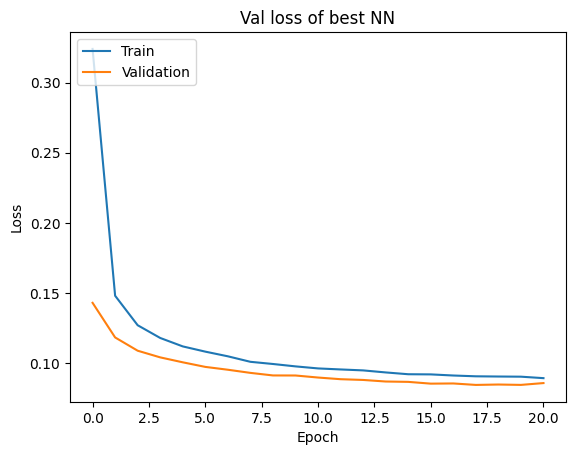

In [73]:
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Retrain on the development set, by taking the best model and test it on the test set.

In [76]:
# Builds NN architecture based on the best nn
model = createModel(layersConfig[index_best_nn][0],layersConfig[index_best_nn][1],"relu","sigmoid")
model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize

# Train the model on the development set
final_history = model.fit(X_sc_trvl, y_trvl, validation_data = (X_sc_test, y_test), epochs=20, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_sc_test, verbose=0))

[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266BF24CCD0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF24EB00>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B67A0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B98B67D0>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B4D30>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B60E0>]


In [81]:
report_scores(y_test, y_pred_test)

              precision    recall  f1-score   support

 non-killing       0.99      0.98      0.99     21553
     killing       0.94      0.96      0.95      6578

    accuracy                           0.98     28131
   macro avg       0.97      0.97      0.97     28131
weighted avg       0.98      0.98      0.98     28131

